In [27]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint, loguniform, uniform

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    f1_score, ConfusionMatrixDisplay,
    confusion_matrix, roc_curve, roc_auc_score, make_scorer,
    classification_report, log_loss
)
from xgboost import XGBClassifier

In [28]:
df = pd.read_csv('../data/processed/pulsar_processed.csv')
df.head()

,PC1,PC2,PC3,PC4,PC5,target_class
0,-1.278849,1.273133,0.016213,0.662102,0.577362,0
1,-1.020553,0.201162,0.670478,1.605779,-0.390326,0
2,0.188289,-0.432114,-0.979766,-0.519232,-0.305346,0
3,-1.015466,1.469881,-0.018832,0.938386,0.495189,0
4,-0.822626,-2.123651,0.407953,-0.380922,-0.654083,0


In [29]:
X = df.drop(columns=['target_class'])
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## XGBoost

### Baseline Model

In [30]:
negative_samples = y_train.value_counts()[0]
positive_samples = y_train.value_counts()[1]
scale_pos_weight = negative_samples / positive_samples
print(f'Scale Pos Weight: {scale_pos_weight:.2f}')

Scale Pos Weight: 9.92


In [31]:
xgb_baseline = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.001,
    n_estimators=100,
    max_depth=20,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    gamma=0,
    eval_metric='logloss',
    random_state=42
)

xgb_baseline.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [32]:
y_pred = xgb_baseline.predict(X_test)

y_pred_proba = xgb_baseline.predict_proba(X_test)[:, 1]

In [33]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.87      0.89      0.88       328

    accuracy                           0.98      3580
   macro avg       0.93      0.94      0.94      3580
weighted avg       0.98      0.98      0.98      3580



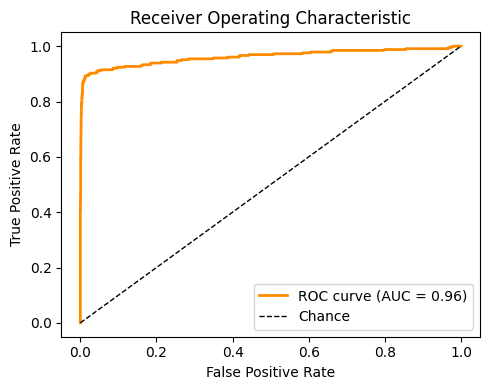

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

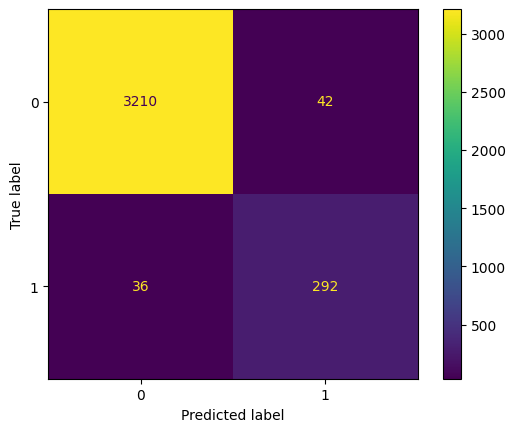

In [35]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [36]:
print(f'Log  Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log  Loss: 0.6146


### Hyperparameter Tuning with Random Search and CV

In [37]:
param_dist = {
    'learning_rate': loguniform(1e-3, 0.3),  # More practical range
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),  # Shallower trees
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
    'gamma': loguniform(1e-3, 10),  # Regularization parameter
}

In [38]:
xgb_model_cv = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    estimator=xgb_model_cv,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=kfolds,
)

In [39]:
random_search.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....t 0x110b1aab0>, 'gamma': <scipy.stats....t 0x11133e000>, 'learning_rate': <scipy.stats....t 0x110b06180>, 'max_depth': <scipy.stats....t 0x111363a10>, ...}"
,n_iter,10
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [40]:
"""
Best params: {'colsample_bytree': np.float64(0.800059140775353), 'gamma': np.float64(0.02102008144343605), 'learning_rate': np.float64(0.05883696510601538), 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 946, 'subsample': np.float64(0.6872471823485685)}
Best cross-validated F1 score: 0.8619
"""
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print(f'Best params: {best_params}')
best_score = random_search.best_score_
print(f'Best cross-validated F1 score: {best_score:.4f}')

Best params: {'colsample_bytree': np.float64(0.800059140775353), 'gamma': np.float64(0.02102008144343605), 'learning_rate': np.float64(0.05883696510601538), 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 946, 'subsample': np.float64(0.6872471823485685)}
Best cross-validated F1 score: 0.8619


In [41]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3252
           1       0.84      0.89      0.87       328

    accuracy                           0.97      3580
   macro avg       0.92      0.94      0.93      3580
weighted avg       0.98      0.97      0.98      3580



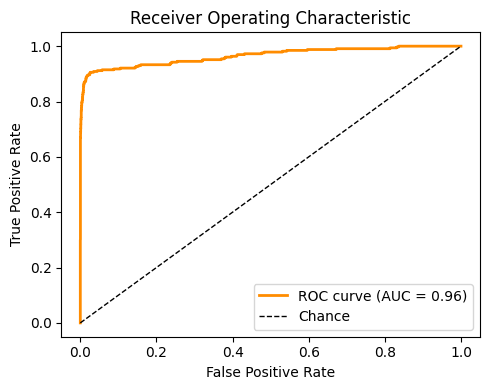

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

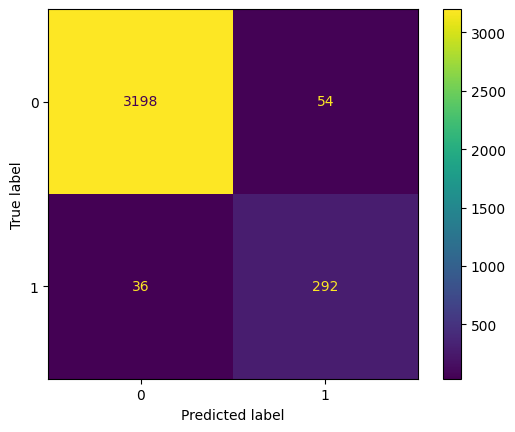

In [43]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [45]:
# Export the best model
import joblib
joblib.dump(best_model, '../models/xgb_best_model.pkl')

['../models/xgb_best_model.pkl']